In [1]:
from glob import glob 

In [2]:
files = glob("../data/lc/*.dat")
files.sort()
files

['../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_gp_10px_bjd-flux-err-am.dat',
 '../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_ip_10px_bjd-flux-err-am.dat',
 '../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_rp_10px_bjd-flux-err-am.dat',
 '../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_zs_10px_bjd-flux-err-am.dat']

In [3]:
import pandas as pd

colnames = "time flux err airmass".split()
lcs = {}
for f in files:
    b = f.split("_")[-3]
    lc = pd.read_csv(f, delimiter="\t", names=colnames, comment='#')
    lcs[b] = lc
    print(f"{b}: {lc.shape}")

gp: (35, 4)
ip: (89, 4)
rp: (41, 4)
zs: (131, 4)


In [4]:
lcs['gp'].head()

,time,flux,err,airmass
0,2.459207e+06,0.999639,0.005508,1.690677
1,2.459207e+06,0.998265,0.003878,1.628061
2,2.459207e+06,0.999853,0.003655,1.599124
3,2.459207e+06,1.000971,0.003558,1.571578
4,2.459207e+06,0.999497,0.003525,1.545440


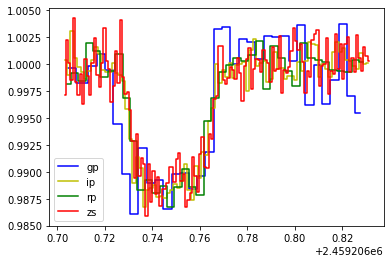

In [5]:
import matplotlib.pyplot as pl

colors = {"gp": "b",
          "rp": "g", 
          "ip": "y", 
          "zs": "r"
         }

for b in lcs:
    t = lcs[b]['time']
    f = lcs[b]['flux']
#     pl.plot(t, f, c=colors[b], marker='.', ls='', label=b)
    pl.plot(t, f, c=colors[b], drawstyle='steps-mid', label=b)
pl.legend()

## LPF

* https://github.com/hpparvi/parviainen_2020_toi_519/tree/main/src
* 

In [7]:
#https://github.com/hpparvi/parviainen_2020_toi_519/blob/main/519/tess_and_m2.ipynb

from typing import Union

import pandas as pd
import xarray as xa
import seaborn as sb

from copy import copy
from pathlib import Path

from astropy.io import fits as pf
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.units import Rjup, Rsun, m, AU

from numpy import zeros, diff, concatenate, sqrt, degrees, radians, array, arange, where
from numpy.random.mtrand import normal, uniform
from uncertainties import ufloat, nominal_value

from pytransit.orbits import as_from_rhop, i_from_ba, d_from_pkaiews, epoch
from pytransit.utils.eclipses import Teq
from pytransit.utils.keplerlc import KeplerLC
from pytransit.lpf.tess.tgclpf import BaseTGCLPF

# TESS routines
# -------------

def read_tess(dfile: Path, zero_epoch: float, period: float, use_pdc: bool = False,
              transit_duration_d: float = 0.1, baseline_duration_d: float = 0.3):
    fcol = 'PDCSAP_FLUX' if use_pdc else 'SAP_FLUX'
    tb = Table.read(dfile)
    bjdrefi = tb.meta['BJDREFI']
    df = tb.to_pandas().dropna(subset=['TIME', 'SAP_FLUX', 'PDCSAP_FLUX'])
    lc = KeplerLC(df.TIME.values + bjdrefi, df[fcol].values, zeros(df.shape[0]),
                  nominal_value(zero_epoch), nominal_value(period), transit_duration_d, baseline_duration_d)
    times, fluxes = copy(lc.time_per_transit), copy(lc.normalized_flux_per_transit)
    if use_pdc:
        contamination = 1 - tb.meta['CROWDSAP']
        fluxes = [contamination + (1 - contamination)*f for f in fluxes]
    ins = len(times)*["TESS"]
    piis = list(arange(len(times)))
    return times, fluxes, len(times)*['tess'], [diff(concatenate(fluxes)).std() / sqrt(2)], ins, piis

class LPF(BaseTGCLPF):
    
    def read_data(self):
        times_t, fluxes_t, pbs_t, wns_t = read_tess(tess_file, zero_epoch.n, period.n, baseline_duration_d=0.15)
        times_m, fluxes_m, pbs_m, wns_m, covs_m = read_m2(reduced_m2_files)

        times = times_t + times_m
        fluxes= fluxes_t + fluxes_m
        pbs = pbs_t + pbs_m
        wns = wns_t + wns_m
        covs = len(times_t)*[array([[]])] + covs_m

        self._stess = len(times_t)
        self._ntess = sum([t.size for t in times_t])
        pbnames = 'tess g r i z_s'.split()
        
        return times, fluxes, pbnames, pbs, wns, covs 

## LPF: single-band

In [6]:
import math as mt
import pandas as pd
import seaborn as sb
import warnings
from numpy import log, pi, inf, atleast_2d, zeros, sqrt, isfinite, clip, where, random, array, ndarray, median, squeeze, seterr, asarray, percentile
from matplotlib.pyplot import subplots, setp

with warnings.catch_warnings():
    cp = sb.color_palette()

from pathlib import Path
from IPython.display import display, HTML
from numba import njit, prange
from astropy.io import fits as pf
from emcee import EnsembleSampler
from tqdm.auto import tqdm
from corner import corner

# from ldtk import LDPSetCreator
from pytransit import QuadraticModel
from pytransit.utils.de import DiffEvol
from pytransit.orbits.orbits_py import as_from_rhop,  i_from_ba
from pytransit.param.parameter import (ParameterSet, GParameter, PParameter, LParameter,
                                       NormalPrior as NP, 
                                       UniformPrior as UP)
seterr('ignore')
random.seed(0)

In [7]:
@njit(parallel=True, cache=False, fastmath=True)
def lnlike_normal_v(o, m, e):
    m = atleast_2d(m)
    npv = m.shape[0]
    npt = o.size
    lnl = zeros(npv)
    for i in prange(npv):
        for j in range(npt):
            lnl[i] += -log(e[i]) - 0.5*log(2*pi) - 0.5*((o[j]-m[i,j])/e[i])**2
    return lnl

In [8]:
class LPFunction:
    def __init__(self, name: str, times: ndarray = None, fluxes: ndarray = None):
        
        self.tm = QuadraticModel(klims=(0.05, 0.25), nk=512, nz=512)

        # LPF name
        # --------
        self.name = name
        
        # Declare high-level objects
        # --------------------------
        self.ps = None          # Parametrisation
        self.de = None          # Differential evolution optimiser
        self.sampler = None     # MCMC sampler

        # Initialize data
        # ---------------
        self.times = asarray(times)
        self.fluxes = asarray(fluxes)
        self.tm.set_data(self.times)

        # Define the parametrisation
        # --------------------------
        self.ps = ParameterSet([
            GParameter('tc',  'zero_epoch',       'd',      NP(0.0,  0.1), (-inf, inf)),
            GParameter('pr',  'period',           'd',      NP(1.0, 1e-5), (0,    inf)),
            GParameter('rho', 'stellar_density',  'g/cm^3', UP(0.1, 25.0), (0,    inf)),
            GParameter('b',   'impact_parameter', 'R_s',    UP(0.0,  1.0), (0,      1)),
            GParameter('k2', 'area_ratio', 'A_s', UP(0.05**2, 0.25**2), (0.05**2, 0.25**2)),
            GParameter('q1', 'q1_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('q2', 'q2_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('loge', 'log10_error', '', UP(-4, 0), bounds=(-4, 0))])
        self.ps.freeze()
        
    def create_pv_population(self, npop=50):
        return self.ps.sample_from_prior(npop)
        
    def baseline(self, pv):
        """Multiplicative baseline"""
        return 1.

    def transit_model(self, pv, copy=True):
        pv = atleast_2d(pv)
        
        # Map from sampling parametrisation to the transit model parametrisation
        # ----------------------------------------------------------------------
        k  = sqrt(pv[:, 4])                # Radius ratio
        tc = pv[:, 0]                      # Zero epoch
        p  = pv[:, 1]                      # Orbital period
        sa = as_from_rhop(pv[:, 2], p)     # Scaled semi-major axis
        i  = i_from_ba(pv[:, 3], sa)       # Orbital inclination

        # Map the limb darkening
        # ----------------------
        ldc = zeros((pv.shape[0],2))
        a, b = sqrt(pv[:,5]), 2.*pv[:,6]
        ldc[:,0] = a * b
        ldc[:,1] = a * (1. - b)
        flux = squeeze(self.tm.evaluate(k, ldc, tc, p, sa, i))    
            
        return flux

    def add_t14_prior(self, mean: float, std: float) -> None:
        """Add a normal prior on the transit duration.
        Parameters
        ----------
        mean
        std
        Returns
        -------
        """
        def T14(pv):
            pv = atleast_2d(pv)
            a = as_from_rhop(pv[:,2], pv[:,1])
            t14 = duration_eccentric(pv[:,1], sqrt(pv[:,4]), a, arccos(pv[:,3] / a), 0, 0, 1)
            return norm.logpdf(t14, mean, std)
        self.lnpriors.append(T14)
        
    def flux_model(self, pv):
        return self.transit_model(pv) * self.baseline(pv)

    def residuals(self, pv):
        return self.fluxes - self.flux_model(pv)

    def set_prior(self, pid: int, prior) -> None:
            self.ps[pid].prior = prior

    def lnprior(self, pv):
        return self.ps.lnprior(pv)

    def lnlikelihood(self, pv):
        flux_m = self.flux_model(pv)
        wn = 10**(atleast_2d(pv)[:, 7])
        return lnlike_normal_v(self.fluxes, flux_m, wn)

    def lnposterior(self, pv):
        lnp = self.lnprior(pv) + self.lnlikelihood(pv)
        return where(isfinite(lnp), lnp, -inf)

    def __call__(self, pv):
        return self.lnposterior(pv)

    def optimize(self, niter=200, npop=50, population=None, label='Global optimisation', leave=False):
        if self.de is None:
            self.de = DiffEvol(self.lnposterior, clip(self.ps.bounds, -1, 1), npop, maximize=True, vectorize=True)
            if population is None:
                self.de._population[:, :] = self.create_pv_population(npop)
            else:
                self.de._population[:,:] = population
        for _ in tqdm(self.de(niter), total=niter, desc=label, leave=leave):
            pass

    def sample(self, niter=500, thin=5, label='MCMC sampling', reset=True, leave=True):
        if self.sampler is None:
            self.sampler = EnsembleSampler(self.de.n_pop, self.de.n_par, self.lnposterior, vectorize=True)
            pop0 = self.de.population
        else:
            pop0 = self.sampler.chain[:,-1,:].copy()
        if reset:
            self.sampler.reset()
        for _ in tqdm(self.sampler.sample(pop0, iterations=niter, thin=thin), total=niter, desc=label, leave=False):
            pass

    def posterior_samples(self, burn: int=0, thin: int=1):
        fc = self.sampler.chain[:, burn::thin, :].reshape([-1, self.de.n_par])
        return pd.DataFrame(fc, columns=self.ps.names)

    def plot_mcmc_chains(self, pid: int=0, alpha: float=0.1, thin: int=1, ax=None):
        fig, ax = (None, ax) if ax is not None else subplots()
        ax.plot(self.sampler.chain[:, ::thin, pid].T, 'k', alpha=alpha)
        fig.tight_layout()
        return fig

    def plot_light_curve(self, model: str = 'de', figsize: tuple = (13, 4)):
        fig, ax = subplots(figsize=figsize, constrained_layout=True)
        cp = sb.color_palette()

        if model == 'de':
            pv = self.de.minimum_location
            err = 10**pv[7]
        elif model == 'mc':
            fc = array(self.posterior_samples())
            pv = random.permutation(fc)[:300]
            err = 10**median(pv[:, 7], 0)

        ax.errorbar(self.times, self.fluxes, err, fmt='.', c=cp[4], alpha=0.75)

        if model == 'de':
            ax.plot(self.times, self.flux_model(pv), c=cp[0])
        if model == 'mc':
            flux_pr = self.flux_model(fc[random.permutation(fc.shape[0])[:1000]])
            flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))
            [ax.fill_between(self.times, *flux_pc[i:i+2,:], alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
            ax.plot(self.times, flux_pc[0], c=cp[0])
        setp(ax, xlim=self.times[[0,-1]], xlabel='Time', ylabel='Normalised flux')
        return fig, ax


In [9]:
b = 'zs'
time = lcs[b]['time']
flux = lcs[b]['flux']

npop, de_iter, mc_reps, mc_iter, thin = 100, 200, 3, 500, 10
lpf = LPFunction('Ks', time, flux)

In [10]:
lpf.optimize(de_iter, npop)

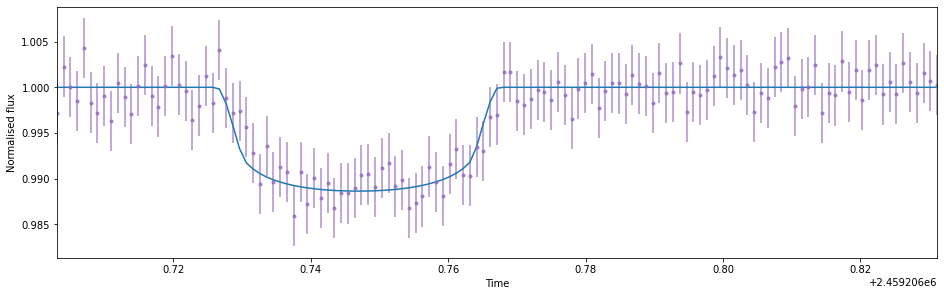

In [11]:
lpf.plot_light_curve();

In [12]:
for i in range(mc_reps):
    lpf.sample(mc_iter, thin=thin, reset=True, label='MCMC sampling')

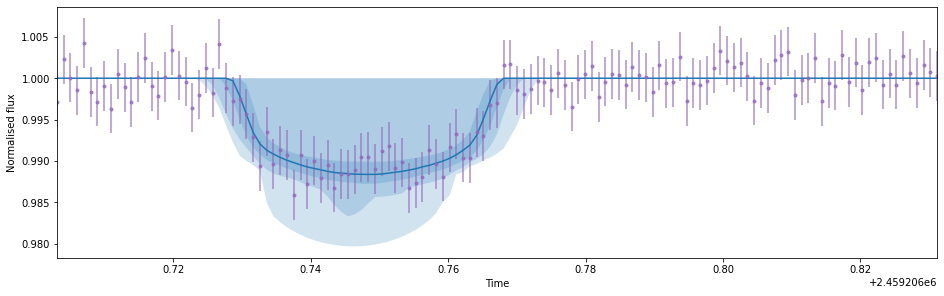

In [13]:
lpf.plot_light_curve('mc');

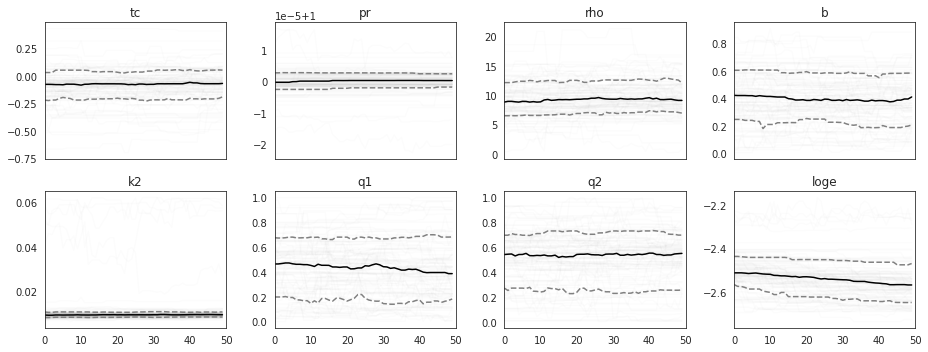

In [15]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
    ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
    [axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
    [[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
    [axs.flat[i].set_title(lpf.ps.names[i]) for i in range(8)]
    setp(axs, xlim=[0,mc_iter//10])
    fig.tight_layout()

In [16]:
pd.set_option('display.precision',4)

df = lpf.posterior_samples()
df['k'] = sqrt(df.k2)
df['u'] = 2*sqrt(df.q1)*df.q2
df['v'] = sqrt(df.q1)*(1-2*df.q2)
df = df.drop('k2', axis=1)
df.describe()

,tc,pr,rho,b,q1,q2,loge,k,u,v
count,5000.0000,5.0000e+03,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000,5000.0000
mean,-0.0889,1.0000e+00,9.5839,0.3995,0.4361,0.5077,-2.5332,0.1033,0.6537,-0.0248
std,0.1614,3.8332e-06,3.0621,0.1811,0.2382,0.2222,0.0961,0.0293,0.3881,0.3062
min,-0.6969,9.9998e-01,0.2007,0.0036,0.0007,0.0044,-2.7374,0.0795,0.0019,-0.9715
25%,-0.1596,1.0000e+00,7.5398,0.2789,0.2492,0.3767,-2.5948,0.0933,0.3239,-0.2016
50%,-0.0698,1.0000e+00,9.2567,0.3944,0.4363,0.5408,-2.5382,0.0969,0.6119,-0.0404
75%,-0.0113,1.0000e+00,11.5412,0.5285,0.5918,0.6536,-2.4878,0.1008,0.9300,0.1302
max,0.4324,1.0000e+00,21.3620,0.9089,0.9974,0.9970,-2.1661,0.2496,1.9504,0.7919


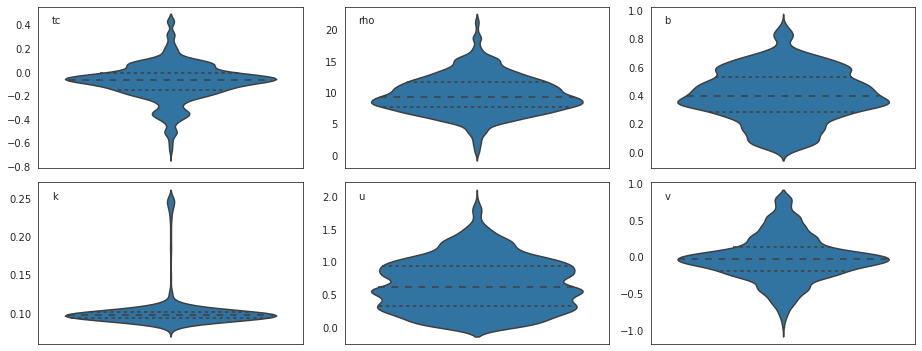

In [17]:
with sb.axes_style('white'):
    fig, axs = subplots(2,3, figsize=(13,5))
    pars = 'tc rho b k u v'.split()
    [sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
    [axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
    setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

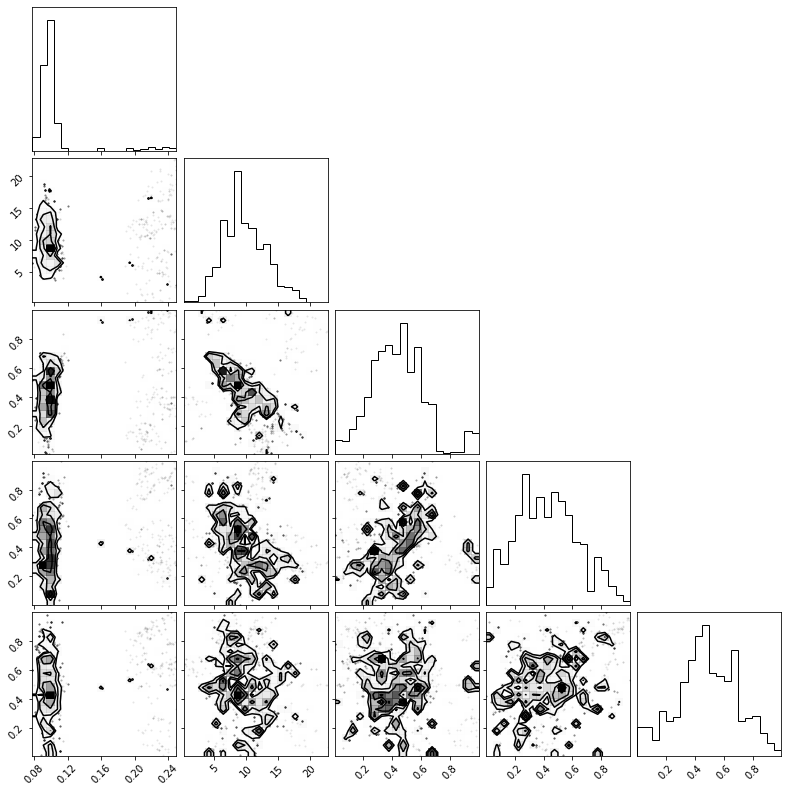

In [24]:
from corner import corner

corner(df[['k', 'rho', 'b', 'q1', 'q2']]);

## multi-band

In [41]:
[lcs[b]['time'].values for b in lcs]

[array([2459206.704304, 2459206.711328, 2459206.714841, 2459206.718354,
        2459206.721867, 2459206.72538 , 2459206.728892, 2459206.732404,
        2459206.735918, 2459206.73943 , 2459206.742942, 2459206.746454,
        2459206.749967, 2459206.75348 , 2459206.756992, 2459206.760505,
        2459206.764017, 2459206.767529, 2459206.771041, 2459206.774554,
        2459206.778066, 2459206.781579, 2459206.785092, 2459206.788605,
        2459206.792117, 2459206.79563 , 2459206.799143, 2459206.802656,
        2459206.806168, 2459206.809681, 2459206.813194, 2459206.816706,
        2459206.820221, 2459206.823734, 2459206.827246]),
 array([2459206.703262, 2459206.70471 , 2459206.706157, 2459206.707605,
        2459206.709067, 2459206.710514, 2459206.711962, 2459206.713409,
        2459206.714858, 2459206.716306, 2459206.717753, 2459206.719201,
        2459206.720648, 2459206.722096, 2459206.723543, 2459206.72499 ,
        2459206.726439, 2459206.727887, 2459206.729344, 2459206.730791,
      

In [54]:
# import pdb
%pdb

from pytransit.lpf.lpf import BaseLPF, map_pv, map_ldc
from numpy import atleast_2d, zeros, exp, log, array, nanmedian, concatenate, ones, arange, where, diff, inf, arccos, \
    sqrt, squeeze, floor, linspace, pi, c_, any, all, percentile, median, repeat, mean, newaxis, isfinite, pad, clip, \
    delete, s_, log10, argsort, atleast_1d, tile, any, fabs, zeros_like, sort

class LPFunction:
    def __init__(self, name: str, data: dict):
        
        self.data = data
        self.bands = list(data.keys())
        times =  [self.data[b]['time'].values for b in self.bands]
        fluxes = [self.data[b]['flux'].values for b in self.bands]
        fluxes = [f/nanmedian(f) for f in fluxes]
        
        self.tm = QuadraticModel(klims=(0.05, 0.25), nk=512, nz=512)

        # LPF name
        # --------
        self.name = name
        
        # Declare high-level objects
        # --------------------------
        self.ps = None          # Parametrisation
        self.de = None          # Differential evolution optimiser
        self.sampler = None     # MCMC sampler

        # Initialize data
        # ---------------
        #pdb.set_trace()
        self.times = asarray(times)
        self.fluxes = asarray(fluxes)
        self.tm.set_data(self.times[0])

        # Define the parametrisation
        # --------------------------
        self.ps = ParameterSet([
            GParameter('tc',  'zero_epoch',       'd',      NP(0.0,  0.1), (-inf, inf)),
            GParameter('pr',  'period',           'd',      NP(1.0, 1e-5), (0,    inf)),
            GParameter('rho', 'stellar_density',  'g/cm^3', UP(0.1, 25.0), (0,    inf)),
            GParameter('b',   'impact_parameter', 'R_s',    UP(0.0,  1.0), (0,      1)),
            GParameter('k2_g', 'area_ratio', 'A_s', UP(0.05**2, 0.25**2), (0.05**2, 0.25**2)),
            GParameter('k2_r', 'area_ratio', 'A_s', UP(0.05**2, 0.25**2), (0.05**2, 0.25**2)),
            GParameter('k2_i', 'area_ratio', 'A_s', UP(0.05**2, 0.25**2), (0.05**2, 0.25**2)),
            GParameter('k2_z', 'area_ratio', 'A_s', UP(0.05**2, 0.25**2), (0.05**2, 0.25**2)),
            GParameter('q1_g', 'q1_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('q2_g', 'q2_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('q1_r', 'q1_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('q2_r', 'q2_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('q1_i', 'q1_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('q2_i', 'q2_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('q1_z', 'q1_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('q2_z', 'q2_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('loge', 'log10_error', '', UP(-4, 0), bounds=(-4, 0))])
        self._sl_ld = slice(6, 10, None)
        self._sl_k2 = slice(10, 18, None)
        self.npb = len(self.data)
        self.lcids = range(self.npb)
        self.pbids = range(self.npb) 
        self.ps.freeze()
        
    def create_pv_population(self, npop=50):
        return self.ps.sample_from_prior(npop)
        
    def baseline(self, pv):
        """Multiplicative baseline"""
        return 1.

    def transit_model_single(self, pv, copy=True):
        pv = atleast_2d(pv)
        
        # Map from sampling parametrisation to the transit model parametrisation
        # ----------------------------------------------------------------------
        k  = sqrt(pv[:, 4])                # Radius ratio
        tc = pv[:, 0]                      # Zero epoch
        p  = pv[:, 1]                      # Orbital period
        sa = as_from_rhop(pv[:, 2], p)     # Scaled semi-major axis
        i  = i_from_ba(pv[:, 3], sa)       # Orbital inclination

        # Map the limb darkening
        # ----------------------
        ldc = zeros((pv.shape[0],2))
        a, b = sqrt(pv[:,5]), 2.*pv[:,6]
        ldc[:,0] = a * b
        ldc[:,1] = a * (1. - b)
        flux = squeeze(self.tm.evaluate(k, ldc, tc, p, sa, i))
            
        return flux
    
    def transit_model(self, pv, copy=True):
        pv = atleast_2d(pv)
        
        mean_ar = pv[:, self._sl_k2].mean(1)
        pvv = zeros((pv.shape[0], pv.shape[1]-self.npb+1))
        pvv[:, :4] = pv[:, :4]
        pvv[:, 4] = mean_ar
        pvv[:, 5:] = pv[:, 4+self.npb:]

        pvp = map_pv(pvv)
        ldc = map_ldc(pvv[:, 5:5 + 2 * self.npb])
        flux = self.tm.evaluate_pv(pvp, ldc, copy)
        rel_ar = pv[:, self._sl_k2] / mean_ar[:,newaxis]
        flux = change_depth(rel_ar, flux, self.lcids, self.pbids)
        
        return flux

    def add_t14_prior(self, mean: float, std: float) -> None:
        """Add a normal prior on the transit duration.
        Parameters
        ----------
        mean
        std
        Returns
        -------
        """
        def T14(pv):
            pv = atleast_2d(pv)
            a = as_from_rhop(pv[:,2], pv[:,1])
            t14 = duration_eccentric(pv[:,1], sqrt(pv[:,4]), a, arccos(pv[:,3] / a), 0, 0, 1)
            return norm.logpdf(t14, mean, std)
        self.lnpriors.append(T14)
        
    def flux_model(self, pv):
        return self.transit_model(pv) * self.baseline(pv)

    def residuals(self, pv):
        return self.fluxes - self.flux_model(pv)

    def set_prior(self, pid: int, prior) -> None:
            self.ps[pid].prior = prior

    def lnprior(self, pv):
        return self.ps.lnprior(pv)

    def lnlikelihood(self, pv):
        flux_m = self.flux_model(pv)
        wn = 10**(atleast_2d(pv)[:, 7])
        return lnlike_normal_v(self.fluxes, flux_m, wn)

    def lnposterior(self, pv):
        lnp = self.lnprior(pv) + self.lnlikelihood(pv)
        return where(isfinite(lnp), lnp, -inf)

    def __call__(self, pv):
        return self.lnposterior(pv)

    def optimize(self, niter=200, npop=50, population=None, label='Global optimisation', leave=False):
        if self.de is None:
            self.de = DiffEvol(self.lnposterior, clip(self.ps.bounds, -1, 1), npop, maximize=True, vectorize=True)
            if population is None:
                self.de._population[:, :] = self.create_pv_population(npop)
            else:
                self.de._population[:,:] = population
        for _ in tqdm(self.de(niter), total=niter, desc=label, leave=leave):
            pass

    def sample(self, niter=500, thin=5, label='MCMC sampling', reset=True, leave=True):
        if self.sampler is None:
            self.sampler = EnsembleSampler(self.de.n_pop, self.de.n_par, self.lnposterior, vectorize=True)
            pop0 = self.de.population
        else:
            pop0 = self.sampler.chain[:,-1,:].copy()
        if reset:
            self.sampler.reset()
        for _ in tqdm(self.sampler.sample(pop0, iterations=niter, thin=thin), total=niter, desc=label, leave=False):
            pass

    def posterior_samples(self, burn: int=0, thin: int=1):
        fc = self.sampler.chain[:, burn::thin, :].reshape([-1, self.de.n_par])
        return pd.DataFrame(fc, columns=self.ps.names)

    def plot_mcmc_chains(self, pid: int=0, alpha: float=0.1, thin: int=1, ax=None):
        fig, ax = (None, ax) if ax is not None else subplots()
        ax.plot(self.sampler.chain[:, ::thin, pid].T, 'k', alpha=alpha)
        fig.tight_layout()
        return fig

    def plot_light_curve(self, model: str = 'de', figsize: tuple = (13, 4)):
        fig, ax = subplots(figsize=figsize, constrained_layout=True)
        cp = sb.color_palette()

        if model == 'de':
            pv = self.de.minimum_location
            err = 10**pv[7]
        elif model == 'mc':
            fc = array(self.posterior_samples())
            pv = random.permutation(fc)[:300]
            err = 10**median(pv[:, 7], 0)

        ax.errorbar(self.times, self.fluxes, err, fmt='.', c=cp[4], alpha=0.75)

        if model == 'de':
            ax.plot(self.times, self.flux_model(pv), c=cp[0])
        if model == 'mc':
            flux_pr = self.flux_model(fc[random.permutation(fc.shape[0])[:1000]])
            flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))
            [ax.fill_between(self.times, *flux_pc[i:i+2,:], alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
            ax.plot(self.times, flux_pc[0], c=cp[0])
        setp(ax, xlim=self.times[[0,-1]], xlabel='Time', ylabel='Normalised flux')
        return fig, ax


Automatic pdb calling has been turned ON


In [55]:
bands = list(lcs.keys())
bands

['gp', 'ip', 'rp', 'zs']

In [56]:
target='toi1696'

lpf = LPFunction(target, lcs)

In [57]:
lpf.optimize()

ValueError: The quadratic model needs two limb darkening coefficients per passband

> /home/jp/github/research/transit/PyTransit/pytransit/models/numba/ma_quadratic_nb.py(663)quadratic_model_pv()
    661 
    662     if ldc.shape[1] != 2*npb:
--> 663         raise ValueError("The quadratic model needs two limb darkening coefficients per passband")
    664     if ldc.shape[0] != pvp.shape[0]:
    665         raise ValueError(

ipdb> exit


In [12]:
times,fluxes,errors,pbids=[],[],[],[]
for i,b in enumerate(['gp', 'rp', 'ip', 'zs']):
    t = lcs[b]['time'].values
    f = lcs[b]['flux']
    e = lcs[b]['err']
    times.append(t)
    fluxes.append(f)
    errors.append(e)
    pbids.append(i)

In [14]:
from pytransit.lpf.logposteriorfunction import LogPosteriorFunction

lpf = LogPosteriorFunction(name=target)

In [27]:
from pytransit.lpf import  BaseLPF

blpf = BaseLPF(name=target, 
               passbands=bands,
               times=times,
               fluxes=fluxes,
               errors=errors
              )

In [39]:
[b in bands for b in list(lcs.keys())]

[True, True, True, True]

In [ ]:
import warnings
import seaborn as sb
from os.path import join, split

from ldtk import LDPSetCreator
from matplotlib.pyplot import subplots, setp, figure
from muscat2ph.catalog import get_toi
from numba import njit, prange
from numpy import atleast_2d, zeros, exp, log, array, nanmedian, concatenate, ones, arange, where, diff, inf, arccos, \
    sqrt, squeeze, floor, linspace, pi, c_, any, all, percentile, median, repeat, mean, newaxis, isfinite, pad, clip, \
    delete, s_, log10, argsort, atleast_1d, tile, any, fabs, zeros_like, sort
from numpy.polynomial.legendre import legvander
from numpy.random import permutation, uniform, normal
from pytransit import QuadraticModel, QuadraticModelCL
from pytransit.contamination import SMContamination
from pytransit.contamination.filter import sdss_g, sdss_r, sdss_i, sdss_z
from pytransit.contamination.instrument import Instrument
from pytransit.lpf.lpf import BaseLPF, map_pv, map_ldc
from pytransit.orbits.orbits_py import as_from_rhop, duration_eccentric, i_from_ba, d_from_pkaiews
from pytransit.param.parameter import NormalPrior as NP, UniformPrior as UP, LParameter, PParameter, ParameterSet
from pytransit.utils.de import DiffEvol
from scipy.stats import logistic, norm
from uncertainties import ufloatI


@njit
def running_mean(time, flux, npt, width_min):
    btime = linspace(time.min(), time.max(), npt)
    bflux, berror = zeros(npt), zeros(npt)
    for i in range(npt):
        m = fabs(time - btime[i]) < 0.5 * width_min / 60 / 24
        bflux[i] = flux[m].mean()
        berror[i] = flux[m].std() / sqrt(m.sum())
    return btime, bflux, berror


@njit
def transit_inside_obs(pvp, tmin, tmax, limit_min: float = 10.):
    limit = limit_min/60./24.
    a = as_from_rhop(pvp[:,2], pvp[:,1])
    i = i_from_ba(pvp[:, 3], a)
    duration = d_from_pkaiews(pvp[:,1], sqrt(pvp[:,4]), a, i, 0, 0, 1)
    ingress = pvp[:,0] + 0.5*duration
    egress = pvp[:,0] + 0.5*duration
    return (ingress < tmax - limit) & (egress > tmin + limit)


@njit(parallel=True, cache=False, fastmath=True)
def lnlike_logistic_v(o, m, e, lcids):
    m = atleast_2d(m)
    npv = m.shape[0]
    npt = m.shape[1]
    lnl = zeros(npv)
    for i in prange(npv):
        for j in range(npt):
            k = lcids[j]
            t = exp((o[i,j]-m[i,j])/e[i,k])
            lnl[i] += log(t / (e[i,k]*(1.+t)**2))
    return lnl

@njit(parallel=True, cache=False, fastmath=True)
def lnlike_logistic_v1d(o, m, e, lcids):
    m = atleast_2d(m)
    npv = m.shape[0]
    npt = o.size
    lnl = zeros(npv)
    for i in prange(npv):
        for j in range(npt):
            k = lcids[j]
            t = exp((o[j]-m[i,j])/e[i,k])
            lnl[i] += log(t / (e[i,k]*(1.+t)**2))
    return lnl

@njit(parallel=True, cache=False, fastmath=True)
def lnlike_logistic_vbb(o, m, e):
    m = atleast_2d(m)
    npv = m.shape[0]
    npt = o.size
    lnl = zeros(npv)
    for i in prange(npv):
        t = exp((o-m[i,:])/e[i,0])
        lnl[i] = sum(log(t / (e[i,0]*(1.+t)**2)))
    return lnl

@njit
def contaminate(flux, cnt, lcids, pbids):
    flux = atleast_2d(flux)
    npv = flux.shape[0]
    npt = flux.shape[1]
    for ipv in range(npv):
        for ipt in range(npt):
            c = cnt[ipv, pbids[lcids[ipt]]]
            flux[ipv, ipt] = c + (1.-c)*flux[ipv, ipt]
    return flux


@njit
def change_depth(relative_depth, flux, lcids, pbids):
    npt = lcids.size
    npop = relative_depth.shape[0]
    flux = atleast_2d(flux)
    flux2 = zeros_like(flux)
    for ipv in range(npop):
        for ipt in range(npt):
            flux2[ipv, ipt] = (flux[ipv, ipt] - 1.) * relative_depth[ipv, pbids[lcids[ipt]]] + 1.
    return flux2

class M2LPF(BaseLPF):
    def __init__(self, 
                 target: str, 
                 data: dict,
                 use_opencl: bool = False,
                 n_legendre: int = 0, 
                 with_contamination=False,
#                  bands: tuple = None, 
                 radius_ratio: str = 'achromatic'
                ):
        assert radius_ratio in ('chromatic', 'achromatic')

        self.data = data
        self.bands = list(data.keys())
#         if bands is None:
#             bands = list(self.data.keys())
#         idx = [b in bands for b in list(self.data.keys())]
#         errmgs = f"{bands[idx]} not in {self.data.keys()}"
#         assert all(idx), errmsg
        
        self.use_opencl = use_opencl
        self.with_contamination = with_contamination
        self.chromatic_transit = radius_ratio == 'chromatic'
        self.radius_ratio = radius_ratio
        self.n_legendre = n_legendre

#         self.covnames = 'intercept sky airmass xshift yshift entropy'.split()
        self.covnames = 'intercept airmass'.split()

        times =  [array(self.data[b]['t']) for b in self.bands]
        fluxes = [array(self.data[b]['f']) for b in self.bands]
        fluxes = [f/nanmedian(f) for f in fluxes]

        self.t0 = floor(times[0].min())
        times = [t - self.t0 for t in times]

        self._tmin = times[0].min()
        self._tmax = times[0].max()

        self.airmasses = [array(self.data[b]['airmass']) for b in self.bands]
        
        covariates = []
        for t,a in zip(times,self.airmasses):
            covs = concatenate([ones([len(t), 1]), a], 1)
            covariates.append(covs)        

        wns = [ones(len(t)) for t in times]

        if use_opencl:
            import pyopencl as cl
            ctx = cl.create_some_context()
            queue = cl.CommandQueue(ctx)
            tm = QuadraticModelCL(klims=(0.005, 0.25), nk=512, nz=512, cl_ctx=ctx, cl_queue=queue)
        else:
            tm = QuadraticModel(interpolate=True, klims=(0.005, 0.25), nk=512, nz=512)

        super().__init__(target, self.bands, times, fluxes, wns, arange(len(self.data)), covariates, arange(len(self.data)), tm=tm)

        self.legendre = [legvander((t - t.min())/(0.5*t.ptp()) - 1, self.n_legendre)[:,1:] for t in self.times]

        # Create the target and reference star flux arrays
        # ------------------------------------------------
#         self.ofluxes = [array(ph.flux[:, self.tid[i], amin:amax+1] / ph.flux[:, self.tid[i], amin:amax+1].median('mjd')) for i,ph in enumerate(photometry)]

#         self.refs = []
#         for ip, ph in enumerate(photometry):
#             self.refs.append([pad(array(ph.flux[:, cid, amin:amax+1]), ((0, 0), (1, 0)), mode='constant') for cid in self.cids[ip]])

#         self.set_orbit_priors()


    def _init_parameters(self):
        self.ps = ParameterSet()
        if self.with_transit:
            self._init_p_orbit()
            self._init_p_planet()
            self._init_p_limb_darkening()
        self._init_p_baseline()
        self._init_p_noise()
        self.ps.freeze()

#     def set_orbit_priors(self):
#         if self.with_transit and self.toi is not None:
#             tn = round((self.times[0].mean() - (self.toi.epoch[0] - self.t0)) / self.toi.period[0])
#             epoch = ufloat(*self.toi.epoch)
#             period = ufloat(*self.toi.period)
#             tc = epoch - self.t0 + tn * period
#             self.set_prior(0, NP(tc.n, tc.s))
#             self.set_prior(1, NP(*self.toi.period))
#             self.add_t14_prior(self.toi.duration[0] / 24, 0.5 * self.toi.duration[1] / 24)


    def _init_p_planet(self):
        """Planet parameter initialisation.
        """
        if self.radius_ratio == 'achromatic':
            pk2 = [PParameter('k2', 'area_ratio', 'A_s', UP(0.005**2, 0.25**2), (0.005**2, 0.25**2))]
            self.ps.add_passband_block('k2', 1, 1, pk2)
            self._pid_k2 = repeat(self.ps.blocks[-1].start, self.npb)
        else:
            pk2 = [PParameter(f'k2_{pb}', f'area_ratio {pb}', 'A_s', UP(0.005**2, 0.25**2), (0.005**2, 0.25**2)) for pb in self.passbands]
            self.ps.add_passband_block('k2', 1, self.npb, pk2)
            self._pid_k2 = arange(self.npb) + self.ps.blocks[-1].start
        self._start_k2 = self.ps.blocks[-1].start
        self._sl_k2 = self.ps.blocks[-1].slice

        if self.with_contamination:
            pcn = [PParameter('cnt_ref', 'Reference contamination', '', UP(0., 1.), (0., 1.))]
            pcn.extend([PParameter(f'cnt_{pb}', 'contamination', '', UP(-1., 1.), (-1., 1.)) for pb in self.passbands[1:]])
            self.ps.add_passband_block('contamination', 1, self.npb, pcn)
            self._pid_cn = arange(self.ps.blocks[-1].start, self.ps.blocks[-1].stop)
            self._sl_cn = self.ps.blocks[-1].slice


    def _init_p_baseline(self):
        c = []
        for ilc in range(self.nlc):
            c.append(LParameter(f'ci_{ilc:d}', 'intercept_{ilc:d}', '', NP(1.0, 0.03), bounds=( 0.5, 1.5)))
#             c.append(LParameter(f'cs_{ilc:d}', 'sky_{ilc:d}',       '', NP(0.0, 0.01), bounds=(-0.5, 0.5)))
            c.append(LParameter(f'ca_{ilc:d}', 'airmass_{ilc:d}',   '', NP(0.0, 0.01), bounds=(-0.5, 0.5)))
#             c.append(LParameter(f'cx_{ilc:d}', 'xshift_{ilc:d}',    '', NP(0.0, 0.01), bounds=(-0.5, 0.5)))
#             c.append(LParameter(f'cy_{ilc:d}', 'yshift_{ilc:d}',    '', NP(0.0, 0.01), bounds=(-0.5, 0.5)))
#             c.append(LParameter(f'ce_{ilc:d}', 'entropy_{ilc:d}',   '', NP(0.0, 0.01), bounds=(-0.5, 0.5)))
        self.ps.add_lightcurve_block('ccoef', 2, self.nlc, c)
        self._sl_ccoef = self.ps.blocks[-1].slice
        self._start_ccoef = self.ps.blocks[-1].start

        if self.n_legendre > 0:
            c = []
            for ilc in range(self.nlc):
                for ilg in range(self.n_legendre):
                    c.append(LParameter(f'leg_{ilc:d}_{ilg:d}', f'legendre__{ilc:d}_{ilg:d}', '', NP(0.0, 0.01), bounds=(-0.5, 0.5)))
            self.ps.add_lightcurve_block('legendre_polynomials', self.n_legendre, self.nlc, c)
            self._sl_leg = self.ps.blocks[-1].slice
            self._start_leg = self.ps.blocks[-1].start

#         if not self.photometry_frozen:
#             c = []
#             for ilc in range(self.nlc):
#                 c.append(LParameter(f'tap_{ilc:d}', f'target_aperture__{ilc:d}', '', UP(0.0, 0.999),  bounds=(0.0, 0.999)))
#             self.ps.add_lightcurve_block('apertures', 1, self.nlc, c)
#             self._sl_tap = self.ps.blocks[-1].slice
#             self._start_tap = self.ps.blocks[-1].start

#             c = []
#             for ilc in range(self.nlc):
#                 for irf in range(self.cids.shape[1]):
#                     c.append(LParameter(f'ref_{irf:d}_{ilc:d}', f'comparison_star_{irf:d}_{ilc:d}', '', UP(0.0, 0.999), bounds=( 0.0, 0.999)))
#             self.ps.add_lightcurve_block('rstars', self.cids.shape[1], self.nlc, c)
#             self._sl_ref = self.ps.blocks[-1].slice
#             self._start_ref = self.ps.blocks[-1].start

    def _init_p_noise(self):
        """Noise parameter initialisation.
        """
        pns = [LParameter('loge_{:d}'.format(i), 'log10_error_{:d}'.format(i), '', UP(-3, 0), bounds=(-3, 0)) for i in
               range(self.n_noise_blocks)]
        self.ps.add_lightcurve_block('log_err', 1, self.n_noise_blocks, pns)
        self._sl_err = self.ps.blocks[-1].slice
        self._start_err = self.ps.blocks[-1].start

    def _init_instrument(self):
        self.instrument = Instrument('MuSCAT3', [sdss_g, sdss_r, sdss_i, sdss_z])
        self.cm = SMContamination(self.instrument, "i'")

    def create_pv_population(self, npop=50):
        pvp = self.ps.sample_from_prior(npop)
        if self.with_transit:
            #for sl in self.ps.blocks[1].slices:
            #    pvp[:,sl] = uniform(0.01**2, 0.25**2, size=(npop, 1))

            if self.with_contamination:
                p = pvp[:, self._sl_cn]
                p[:, 1]  = uniform(size=npop)
                p[:, 1:] = normal(0, 0.2, size=(npop, self.npb - 1))
                p[:, 1:] = clip(p[:, 0][:, newaxis] + p[:, 1:], 0.001, 0.999) - p[:, 0][:, newaxis]

            # With LDTk
            # ---------
            #
            # Use LDTk to create the sample if LDTk has been initialised.
            #
            if self.ldps:
                istart = self._start_ld
                cms, ces = self.ldps.coeffs_tq()
                for i, (cm, ce) in enumerate(zip(cms.flat, ces.flat)):
                    pvp[:, i + istart] = normal(cm, ce, size=pvp.shape[0])

            # No LDTk
            # -------
            #
            # Ensure that the total limb darkening decreases towards
            # red passbands.
            #
            else:
                pvv = uniform(size=(npop, 2*self.npb))
                pvv[:, ::2] = sort(pvv[:, ::2], 1)[:, ::-1]
                pvv[:, 1::2] = sort(pvv[:, 1::2], 1)[:, ::-1]
                pvp[:,self._sl_ld] = pvv
                #for i in range(pvp.shape[0]):
                #    pid = argsort(pvp[i, ldsl][::2])[::-1]
                #    pvp[i, ldsl][::2] = pvp[i, ldsl][::2][pid]
                #    pvp[i, ldsl][1::2] = pvp[i, ldsl][1::2][pid]

        # Estimate white noise from the data
        # ----------------------------------
        for i in range(self.nlc):
            wn = diff(self.ofluxa).std() / sqrt(2)
            pvp[:, self._start_err] = log10(uniform(0.5*wn, 2*wn, size=npop))
        return pvp

#     def target_apertures(self, pv):
#         pv = atleast_2d(pv)
#         p = floor(clip(pv[:, self._sl_tap], 0., 0.999) * (self.napt)).astype('int')
#         return squeeze(p)

#     def reference_apertures(self, pv):
#         pv = atleast_2d(pv)
#         p = floor(clip(pv[:, self._sl_ref], 0., 0.999) * (self.napt+1)).astype('int')
#         return squeeze(p)

#     def set_ofluxa(self, pv):
#         self.ofluxa[:] = self.relative_flux(pv)

#     def freeze_photometry(self, pv=None):
#         pv = pv if pv is not None else self.de.minimum_location
#         ps_orig = self.ps
#         self._original_population = pvp = self.de.population.copy()
#         self._frozen_population = delete(pvp, s_[self._sl_tap.start: self._sl_ref.stop], 1)
#         self.taps = self.target_apertures(pv)
#         self.raps = self.reference_apertures(pv)
#         self._target_flux = self.target_flux(pv)
#         self._reference_flux = self.reference_flux(pv)
#         self.ofluxa[:] = self.relative_flux(pv)
#         self.photometry_frozen = True
#         self._init_parameters()
#         if self.with_transit:
#             for i in range(self._start_ld):
#                 self.ps[i].prior = ps_orig[i].prior
#                 self.ps[i].bounds = ps_orig[i].bounds
#         self.de = DiffEvol(self.lnposterior, clip(self.ps.bounds, -1, 1), self.de.n_pop, maximize=True, vectorize=True)
#         self.de._population[:,:] = self._frozen_population.copy()
#         self.de._fitness[:] = self.lnposterior(self._frozen_population)


    def transit_model(self, pv, copy=True):
        if self.with_transit:
            pv = atleast_2d(pv)
            if self.chromatic_transit:
                mean_ar = pv[:, self._sl_k2].mean(1)
                pvv = zeros((pv.shape[0], pv.shape[1]-self.npb+1))
                pvv[:, :4] = pv[:, :4]
                pvv[:, 4] = mean_ar
                pvv[:, 5:] = pv[:, 4+self.npb:]

                pvp = map_pv(pvv)
                ldc = map_ldc(pvv[:, 5:5 + 2 * self.npb])
                flux = self.tm.evaluate_pv(pvp, ldc, copy)
                rel_ar = pv[:, self._sl_k2] / mean_ar[:,newaxis]
                flux = change_depth(rel_ar, flux, self.lcids, self.pbids)
            else:
                flux = super().transit_model(pv, copy)

            if self.with_contamination:
                p = pv[:, self._sl_cn]
                pv_cnt = zeros((pv.shape[0], self.npb))
                pv_cnt[:,0] = p[:,0]
                pv_cnt[:,1:] = p[:,1:] + p[:,0][:, newaxis]
                bad = any(pv_cnt < 0.0, 1)
                flux = contaminate(flux, pv_cnt, self.lcids, self.pbids)
                flux[bad,0] = inf
            return flux
        else:
            return 1.

    def flux_model(self, pv):
        baseline    = self.baseline(pv)
        trends      = self.trends(pv)
        model_flux = self.transit_model(pv, copy=True)
        return baseline * model_flux + trends

#     def relative_flux(self, pv):
#         return self.target_flux(pv) / self.reference_flux(pv)

#     def target_flux(self, pv):
#         pv = atleast_2d(pv)
#         p = floor(clip(pv[:, self._sl_tap], 0., 0.999) * self.napt).astype('int')
#         off = zeros((p.shape[0], self.timea.size))
#         for i, sl in enumerate(self.lcslices):
#             off[:, sl] = self.ofluxes[i][:, p[:, i]].T
#         return squeeze(off)

#     def reference_flux(self, pv):
#         pv = atleast_2d(pv)
#         p = floor(clip(pv[:, self._sl_ref], 0., 0.999) * self.napt+1).astype('int')
#         r = zeros((pv.shape[0], self.ofluxa.size))
#         nref = self.cids.shape[1]
#         for ipb, sl in enumerate(self.lcslices):
#             for i in range(nref):
#                 r[:, sl] += self.refs[ipb][i][:, p[:, ipb * nref + i]].T
#             r[:, sl] = r[:, sl] / median(r[:, sl], 1)[:, newaxis]
#         return squeeze(where(isfinite(r), r, inf))

    def extinction(self, pv):
        pv = atleast_2d(pv)
        ext = zeros((pv.shape[0], self.timea.size))
        for i, sl in enumerate(self.lcslices):
            st = self._start_ccoef + i * 6
            ext[:, sl] = exp(- pv[:, st + 2] * self.airmasses[i][:, newaxis]).T
            ext[:, sl] /= mean(ext[:, sl], 1)[:, newaxis]
        return squeeze(ext)

    def baseline(self, pv):
        pv = atleast_2d(pv)
        bl = zeros((pv.shape[0], self.timea.size))
        for i,sl in enumerate(self.lcslices):
            st = self._start_ccoef + i*6
            p = pv[:, st:st+6]
            #bl[:, sl] = (self.covariates[i] @ p[:,[0,1,3,4,5]].T).T
            bl[:, sl] = (self.covariates[i][:,[0,2,3]] @ p[:,[0,3,4]].T).T

        if self.n_legendre > 0:
            for i, sl in enumerate(self.lcslices):
                st = self._start_leg + i * self.n_legendre
                p = pv[:, st:st + self.n_legendre]
                bl[:, sl] += (self.legendre[i] @ p.T).T
        bl = bl * self.extinction(pv)
        return bl

    def lnlikelihood(self, pv):
        flux_m = self.flux_model(pv)
        wn = 10**(atleast_2d(pv)[:,self._sl_err])
        if self.photometry_frozen:
            return lnlike_logistic_v1d(self.ofluxa, flux_m, wn, self.lcids)
        else:
            return lnlike_logistic_v(self.relative_flux(pv), flux_m, wn, self.lcids)

    def ldprior(self, pv):
        ld = pv[:, self._sl_ld]
        #lds = ld[:,::2] + ld[:, 1::2]
        #return where(any(diff(lds, 1) > 0., 1), -inf, 0.)
        return where(any(diff(ld[:,::2], 1) > 0., 1) | any(diff(ld[:,1::2], 1) > 0., 1), -inf, 0)

    def inside_obs_prior(self, pv):
        return where(transit_inside_obs(pv, self._tmin, self._tmax, 20.), 0., -inf)

    def lnprior(self, pv):
        pv = atleast_2d(pv)
        lnp = self.ps.lnprior(pv)
        if self.with_transit:
            lnp += self.additional_priors(pv) + self.ldprior(pv)
            #lnp += self.ldprior(pv) + self.inside_obs_prior(pv) + self.additional_priors(pv)
        return lnp

    def add_t14_prior(self, mean: float, std: float) -> None:
        """Add a normal prior on the transit duration.
        Parameters
        ----------
        mean
        std
        Returns
        -------
        """
        def T14(pv):
            pv = atleast_2d(pv)
            a = as_from_rhop(pv[:,2], pv[:,1])
            t14 = duration_eccentric(pv[:,1], sqrt(pv[:,4]), a, arccos(pv[:,3] / a), 0, 0, 1)
            return norm.logpdf(t14, mean, std)
        self.lnpriors.append(T14)

    def add_ldtk_prior(self, teff: tuple, logg: tuple, z: tuple,
                       uncertainty_multiplier: float = 3,
                       pbs: tuple = ('g', 'r', 'i', 'z')) -> None:
        """Add a LDTk-based prior on the limb darkening.
        Parameters
        ----------
        teff
        logg
        z
        uncertainty_multiplier
        pbs
        Returns
        -------
        """
        fs = {n: f for n, f in zip('g r i z'.split(), (sdss_g, sdss_r, sdss_i, sdss_z))}
        filters = [fs[k] for k in pbs]
        self.ldsc = LDPSetCreator(teff, logg, z, filters)
        self.ldps = self.ldsc.create_profiles(1000)
        self.ldps.resample_linear_z()
        self.ldps.set_uncertainty_multiplier(uncertainty_multiplier)
        def ldprior(pv):
            pv = atleast_2d(pv)
            lnl = zeros(pv.shape[0])
            for i in range(pv.shape[0]):
                lnl[i] = self.ldps.lnlike_tq(pv[i, self._sl_ld])
            return lnl
        self.lnpriors.append(ldprior)

    def plot_light_curves(self, model: str = 'de', figsize: tuple = (13, 8), fig=None, gridspec=None):
        if fig is None:
            fig = figure(figsize=figsize, constrained_layout=True)

        gs = dict(height_ratios=(0.5, 2, 2, 1))
        if gridspec:
            gs.update(gridspec)

        axs = fig.subplots(4, self.nlc, sharey='row', gridspec_kw=gs)

        if model == 'de':
            pv = self.de.minimum_location
            err = 10 ** pv[self._sl_err]
            if not self.photometry_frozen:
                self.set_ofluxa(pv)

        elif model == 'mc':
            fc = array(self.posterior_samples(include_ldc=True))
            pv = permutation(fc)[:300]
            err = 10 ** median(pv[:, self._sl_err], 0)
            if not self.photometry_frozen:
                self.set_ofluxa(median(pv, 0))
        else:
            raise NotImplementedError("Light curve plotting `model` needs to be either `de` or `mc`")

        ps = [50, 16, 84]
        if self.with_transit:
            tm = percentile(atleast_2d(self.transit_model(pv)), ps, 0)
        else:
            tm = percentile(atleast_2d(ones(self.timea.size)), ps, 0)
        fm = percentile(atleast_2d(self.flux_model(pv)), ps, 0)
        bl = percentile(atleast_2d(self.baseline(pv)), ps, 0)
        t0 = self.t0

        for i, sl in enumerate(self.lcslices):
            t = self.timea[sl]
            axs[1, i].plot(t, self.ofluxa[sl], '.', alpha=0.5)
            axs[1, i].plot(t, fm[0][sl], 'k', lw=2)
            axs[2, i].plot(t, self.ofluxa[sl] / bl[0][sl], '.', alpha=0.5)
            if model == 'mc':
                axs[2, i].fill_between(t, tm[1][sl], tm[2][sl], facecolor='darkblue', alpha=0.25)
            axs[2, i].plot(t, tm[0][sl], 'k', lw=2)
            axs[3, i].plot(t, self.ofluxa[sl] - fm[0][sl], '.', alpha=0.5)

            res = self.ofluxa[sl] - fm[0][sl]
            x = linspace(-4 * err, 4 * err)
            axs[0, i].hist(1e3 * res, 'auto', density=True, alpha=0.5)
            axs[0, i].plot(1e3 * x, logistic(0, 1e3 * err[i]).pdf(1e3 * x), 'k')
            axs[0, i].text(0.05, 0.95, f"$\sigma$ = {(1e3 * err[i] * pi / sqrt(3)):5.2f} ppt",
                           transform=axs[0, i].transAxes, va='top')

        [ax.set_title(f"MuSCAT2 {t}", size='large') for ax, t in zip(axs[0], self.passbands)]
        [setp(ax.get_xticklabels(), visible=False) for ax in axs[1:3].flat]
        setp(axs[1, 0], ylabel='Transit + Systematics')
        setp(axs[2, 0], ylabel='Transit - Systematics')
        setp(axs[3, 0], ylabel='Residuals')
        setp(axs[3, :], xlabel=f'Time - {self.t0:9.0f} [BJD]')
        setp(axs[0, :], xlabel='Residual [ppt]', yticks=[])
        [sb.despine(ax=ax, offset=5, left=True) for ax in axs[0]]
        return fig, axs


    def plot_posteriors(self, figsize: tuple = (13, 5), fig=None, gridspec=None):
        if fig is None:
            fig = figure(figsize=figsize, constrained_layout=True)
        axs = fig.subplots(2, 3, gridspec_kw=gridspec)

        df = self.posterior_samples(include_ldc=True)
        df = df.iloc[:, :5].copy()
        df['k'] = sqrt(df.k2)

        names = 'stellar density, impact parameter, transit depth, radius ratio'.split(', ')

        # Transit centre
        # --------------
        p = self.ps.priors[0]
        t0 = floor(df.tc.mean())
        trange = p.mean - t0 - 3 * p.std, p.mean - t0 + 3 * p.std
        x = linspace(*trange)
        axs[0, 0].hist(df.tc - t0, 50, density=True, range=trange, alpha=0.5, edgecolor='k', histtype='stepfilled')
        axs[0, 0].set_xlabel(f'Transit center - {t0:9.0f} [BJD]')
        axs[0, 0].fill_between(x, exp(p.logpdf(x + t0)), alpha=0.5, edgecolor='k')

        # Period
        # ------
        p = self.ps.priors[1]
        trange = p.mean - 3 * p.std, p.mean + 3 * p.std
        x = linspace(*trange)
        axs[0, 1].hist(df.pr, 50, density=True, range=trange, alpha=0.5, edgecolor='k', histtype='stepfilled')
        axs[0, 1].set_xlabel('Period [days]')
        axs[0, 1].fill_between(x, exp(p.logpdf(x)), alpha=0.5, edgecolor='k')
        setp(axs[0, 1], xticks=df.pr.quantile([0.05, 0.5, 0.95]))

        # Rest without priors
        # -------------------
        for i, ax in enumerate(axs.flat[2:]):
            ax.hist(df.iloc[:, i + 2], 50, density=True, alpha=0.5, edgecolor='k', histtype='stepfilled')
            ax.set_xlabel(names[i])

        # TFOP Transit depth estimates
        axs[1, 1].axvline(1e-6 * self.toi.depth[0], c='0.5', lw=2)
        axs[1, 2].axvline(sqrt(1e-6 * self.toi.depth[0]), c='0.5', lw=2)

        setp(axs, yticks=[])
        return fig, axs

    def plot_chains(self, pids=(0, 1, 2, 3, 4)):
        fig, axs = subplots(len(pids), 1, figsize=(13, 10), constrained_layout=True, sharex='all')
        x = arange(self.sampler.chain.shape[1])
        for i, (pid, ax) in enumerate(zip(pids, axs)):
            pes = percentile(self.sampler.chain[:, :, pid], [50, 16, 84, 0.5, 99.5], 0)
            ax.fill_between(x, pes[3], pes[4])
            ax.fill_between(x, pes[1], pes[2])
            ax.plot(pes[0], 'k')
            setp(ax, ylabel=self.ps.names[pid])
        setp(axs, xlim=(0, x[-1]))

    def plot_running_mean(self, figsize=(13, 5), errors=True, combine=False, remove_baseline=True, ylim=None, npt=100,
                     width_min=10):
        pv = self.de.minimum_location
        rflux = self.relative_flux(pv)
        if remove_baseline:
            rflux /= squeeze(self.baseline(pv))

        if combine:
            bt, bf, be = running_mean(self.timea, rflux, npt, width_min)
            fig, axs = subplots(figsize=figsize, constrained_layout=True)
            if errors:
                axs.errorbar(bt, bf, be, drawstyle='steps-mid', c='k')
            else:
                axs.plot(bt, bf, drawstyle='steps-mid', c='k')
            axs.fill_between(bt, bf - 3 * be, bf + 3 * be, alpha=0.2, step='mid')

        else:
            rfluxes = [rflux[sl] for sl in self.lcslices]
            fig, axs = subplots(1, self.nlc, figsize=figsize, constrained_layout=True, sharey='all')
            for i, ax in enumerate(axs):
                bt, bf, be = running_mean(self.times[i], rfluxes[i], npt, width_min)
                if errors:
                    ax.errorbar(bt, bf, be, drawstyle='steps-mid', c='k')
                else:
                    ax.plot(bt, bf, drawstyle='steps-mid', c='k')

        if ylim:
            setp(axs, ylim=ylim)